## Laboratorio 3 - MLflow y Feast

- Sebastián Silva
- Melissa Pérez

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import mlflow
import feast

### Ejercicio 1 - Configuración del Entorno

In [2]:
def get_version(module, display_name):
    ver = getattr(module, "__version__", None)
    if ver is None:
        print(f"[ADVERTENCIA] No se pudo determinar la versión de {display_name} mediante __version__.")
        return "desconocida"
    return ver

all_ok = True

try:
    import mlflow as _mlflow
    print(f"MLflow está instalado. Versión: {get_version(_mlflow, 'MLflow')}")
except Exception as e:
    print(f"[ERROR] Al importar MLflow: {e}")
    all_ok = False

try:
    import feast as _feast
    print(f"Feast está instalado. Versión: {get_version(_feast, 'Feast')}")
except Exception as e:
    print(f"[ERROR] Al importar Feast: {e}")
    all_ok = False

MLflow está instalado. Versión: 3.5.0
Feast está instalado. Versión: 0.55.0


### Ejercicio 2 - Carga y Exploración de Datos

In [3]:
cal_housing = fetch_california_housing(as_frame=True)
df = cal_housing.frame.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.rename(columns={"MedInc": "median_income", 
                   "HouseAge": "house_age", 
                   "AveRooms": "average_rooms", 
                   "AveOccup": "average_occupants",
                   "Latitude": "latitude",
                   "Longitude": "longitude",
                   "MedHouseVal": "median_house_value"}, inplace=True)

In [6]:
df.head()

,median_income,house_age,average_rooms,AveBedrms,Population,average_occupants,latitude,longitude,median_house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [7]:
print(f"Shape: {df.shape}")
print("\nTipos de datos:")
print(df.dtypes)

Shape: (20640, 9)

Tipos de datos:
median_income         float64
house_age             float64
average_rooms         float64
AveBedrms             float64
Population            float64
average_occupants     float64
latitude              float64
longitude             float64
median_house_value    float64
dtype: object


#### Análisis Exploratorio de Datos

In [8]:
print("Estadísticas descriptivas del dataset:")
display(df.describe().T)

Estadísticas descriptivas del dataset:


,count,mean,std,min,25%,50%,75%,max
median_income,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
house_age,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
average_rooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
average_occupants,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
median_house_value,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [9]:
# Estadísticas adicionales del target
print(f"\nEstadísticas de la variable target (median_house_value):")
print(f"Media: {df['median_house_value'].mean():.2f}")
print(f"Mediana: {df['median_house_value'].median():.2f}")
print(f"Desviación estándar: {df['median_house_value'].std():.2f}")
print(f"Mínimo: {df['median_house_value'].min():.2f}")
print(f"Máximo: {df['median_house_value'].max():.2f}")


Estadísticas de la variable target (median_house_value):
Media: 2.07
Mediana: 1.80
Desviación estándar: 1.15
Mínimo: 0.15
Máximo: 5.00


In [10]:
# Identificación de valores faltantes
missing_values = df.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)
print(f"\nTotal de valores faltantes: {missing_values.sum()}")

Valores faltantes por columna:
median_income         0
house_age             0
average_rooms         0
AveBedrms             0
Population            0
average_occupants     0
latitude              0
longitude             0
median_house_value    0
dtype: int64

Total de valores faltantes: 0


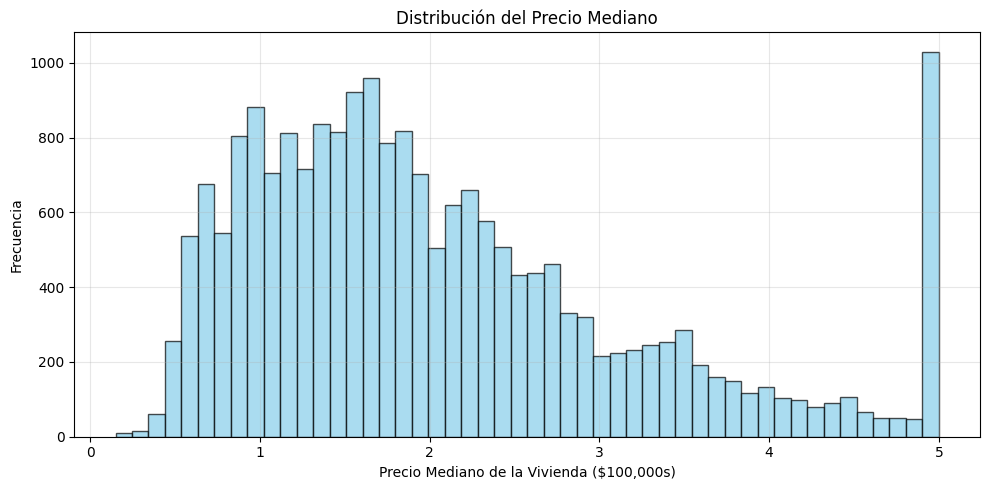

In [11]:
# Histograma - Distribución de la variable target
plt.figure(figsize=(10, 5))
plt.hist(df['median_house_value'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Precio Mediano de la Vivienda ($100,000s)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Precio Mediano')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

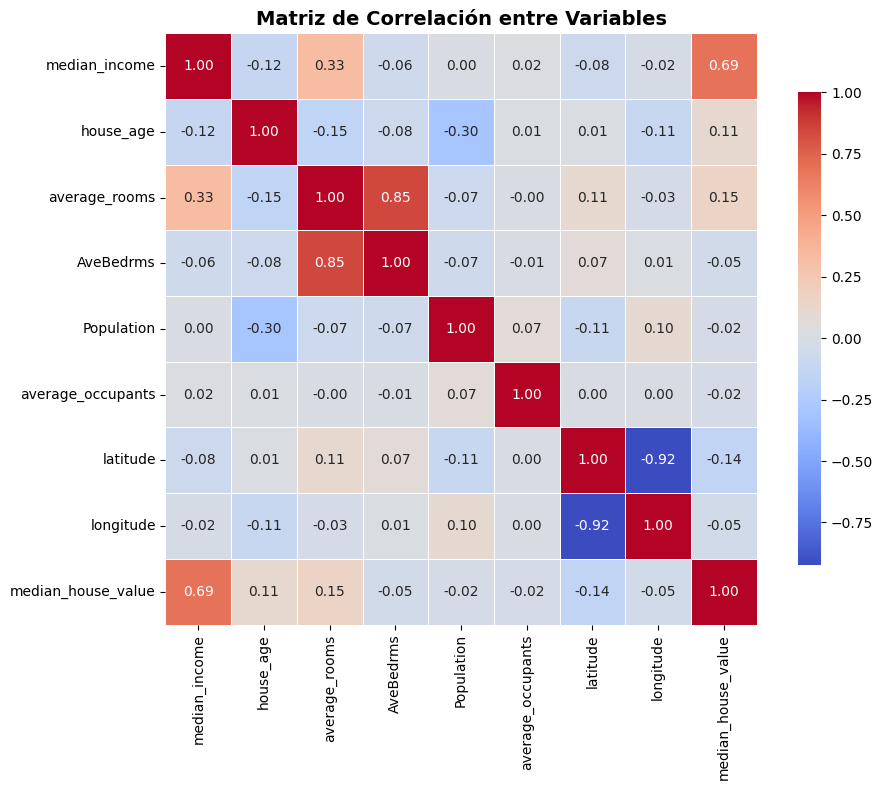

In [12]:
# Matriz de correlación entre variables
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Ejercicio 3 - Preparación de Datos

In [ ]:
# conjuntos de entrenamiento y prueba (80/20)
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

In [14]:
# features derivadas en el conjunto de entrenamiento
X_train['rooms_per_household'] = X_train['average_rooms'] / X_train['average_occupants']
X_train['population_per_household'] = X_train['Population'] / X_train['AveBedrms']
X_train['bedrooms_per_room'] = X_train['AveBedrms'] / X_train['average_rooms']


In [15]:
# features en el conjunto de prueba
X_test['rooms_per_household'] = X_test['average_rooms'] / X_test['average_occupants']
X_test['population_per_household'] = X_test['Population'] / X_test['AveBedrms']
X_test['bedrooms_per_room'] = X_test['AveBedrms'] / X_test['average_rooms']

In [16]:
display(X_train[['rooms_per_household', 'population_per_household', 'bedrooms_per_room']].head())

,rooms_per_household,population_per_household,bedrooms_per_room
14196,1.359130,2285.326954,0.200576
8267,2.573820,1262.241423,0.232703
17445,2.073224,928.821752,0.174486
14265,1.002116,1371.634877,0.258269
2271,2.725400,770.580046,0.180940
